In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_vae import *
import torch
import random
from config import *
import sys
sys.path.append('../esa')
from esa.utils import *
from esa.lstm_utils import *

import platform

import numpy as np

architecture = 'lstm_vae'

In [2]:
model_list = os.listdir(model_results+ '{}/'.format(architecture))
for ix, mn in enumerate(model_list):  
    print('model num {}: {}'.format(ix,model_list[ix]))

model num 0: lstm_vae_sl_16_emb_128_layers_1_1_18_03_2023_17:46:58.pth
model num 1: lstm_vae_sl_40_emb_128_layers_1_1_18_03_2023_17:43:40.pth
model num 2: lstm_vae_sl_16_emb_128_layers_1_1_19_03_2023_12:00:36.pth
model num 3: lstm_vae_sl_40_emb_32_layers_1_1_18_03_2023_12:51:10.pth
model num 4: lstm_vae_sl_40_emb_128_layers_1_1_18_03_2023_17:20:33.pth
model num 5: lstm_vae_sl_16_emb_128_layers_1_1_19_03_2023_12:15:15.pth
model num 6: lstm_vae_sl_40_emb_128_layers_1_1_18_03_2023_17:37:36.pth
model num 7: lstm_vae_sl_40_emb_32_layers_2_2_18_03_2023_12:26:14.pth
model num 8: lstm_vae_sl_16_emb_128_layers_1_1_19_03_2023_12:08:34.pth
model num 9: lstm_vae_sl_40_emb_32_layers_2_2_18_03_2023_12:11:22.pth
model num 10: lstm_vae_sl_40_emb_128_layers_1_1_18_03_2023_17:40:18.pth
model num 11: lstm_vae_sl_16_emb_128_layers_2_2_19_03_2023_12:23:36.pth
model num 12: lstm_vae_sl_16_emb_128_layers_1_1_19_03_2023_08:46:06.pth
model num 13: lstm_vae_sl_40_emb_32_layers_2_2_18_03_2023_12:24:40.pth
model 

In [45]:
selected_model = 0
print(model_list[selected_model])
model_name = model_list[selected_model].split('.')[0]

lstm_vae_sl_40_emb_32_layers_2_2_18_03_2023_12:26:14.pth


In [46]:
checkpoint  = torch.load(model_results+ '{}/'.format(architecture) + '/' + model_list[selected_model])
params_conf = checkpoint['param_conf']

In [47]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [48]:
cols = params_conf['columns']
sequence_length = params_conf['sequence_length']
batch_size = params_conf['batch_size']
predict = params_conf['predict']

out_window = params_conf['out_window']

n_features = params_conf['n_features']
scaled = params_conf['scaled']
sampling_rate = params_conf['sampling_rate']

In [49]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=params_conf['columns'],
columns_subset=params_conf['columns_subset'], dataset_subset=params_conf['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=params_conf['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)  

In [50]:
model = LSTM_VAE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        no_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
        Nf_lognorm=params_conf['n_features'], Nf_binomial=0, n_layers_1=params_conf['n_layers_1'],
        n_layers_2=params_conf['n_layers_2'], kld=params_conf['kld'])
    

LSTM_VAE(
  (encoder): Encoder_vae(
    (LSTMenc): LSTM(16, 64, num_layers=2, batch_first=True)
    (LSTM1): LSTM(64, 32, num_layers=2, batch_first=True)
    (mu): Linear(in_features=32, out_features=100, bias=True)
    (logvar): Linear(in_features=32, out_features=100, bias=True)
  )
  (decoder): Decoder_vae(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(100, 32, num_layers=2, batch_first=True)
    (LSTM1): LSTM(32, 64, num_layers=2, batch_first=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)


In [51]:
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()

LSTM_VAE(
  (encoder): Encoder_vae(
    (LSTMenc): LSTM(16, 64, num_layers=2, batch_first=True)
    (LSTM1): LSTM(64, 32, num_layers=2, batch_first=True)
    (mu): Linear(in_features=32, out_features=100, bias=True)
    (logvar): Linear(in_features=32, out_features=100, bias=True)
  )
  (decoder): Decoder_vae(
    (act2): InverseSquareRootLinearUnit()
    (act3): ClippedTanh()
    (LSTMdec): LSTM(100, 32, num_layers=2, batch_first=True)
    (LSTM1): LSTM(32, 64, num_layers=2, batch_first=True)
    (par1): Linear(in_features=64, out_features=16, bias=True)
    (par2): Linear(in_features=64, out_features=16, bias=True)
    (par3): Linear(in_features=64, out_features=16, bias=True)
  )
)

In [52]:
num_batch = 5
inject_anomalies = False

if inject_anomalies:
    x, shift = unrolling_batches_with_anomalies(num_batch=num_batch, test_iter=test_iter, sigma=3,
                             sequence_length=sequence_length, cols=cols, shift = None)
else:
    x, shift = unrolling_batches(num_batch=num_batch, test_iter=test_iter, 
                         sequence_length=sequence_length, cols=cols, shift = None)

random shift 574


In [53]:
x, mu, log_var, pars  = model(x.to(device))
yo = pars[0]

In [54]:
#sequence_length=50
#out_window=10

In [ ]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

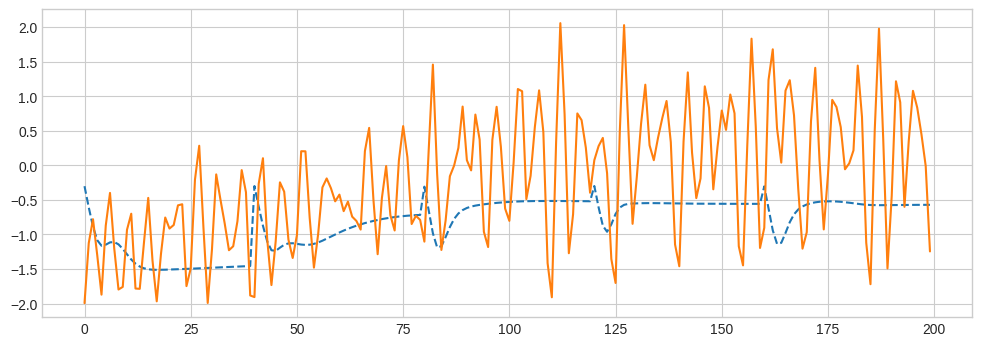

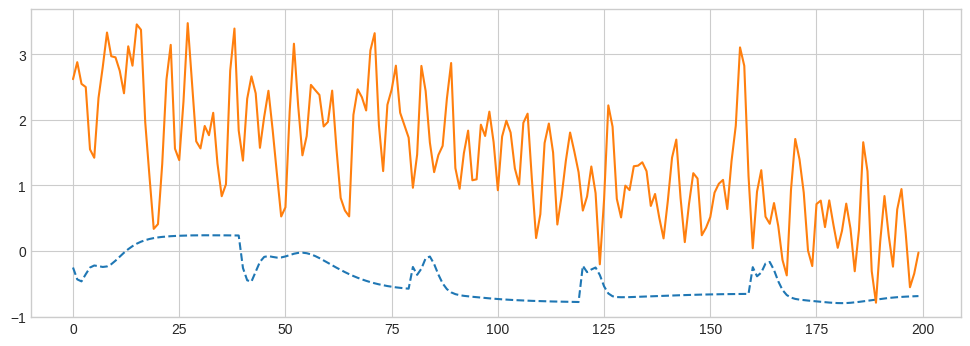

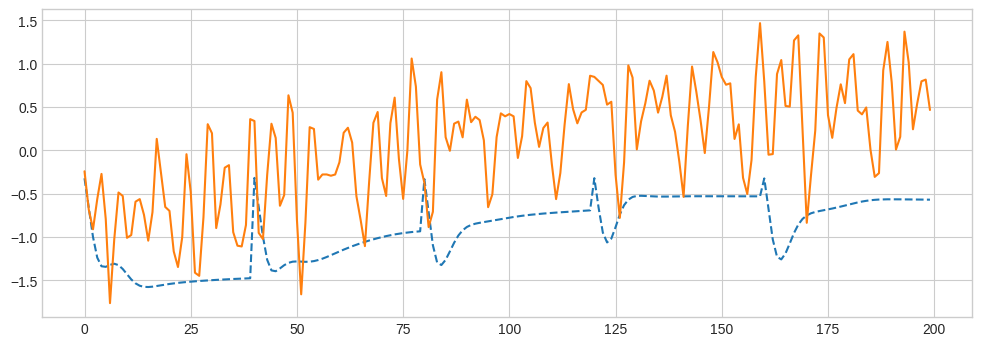

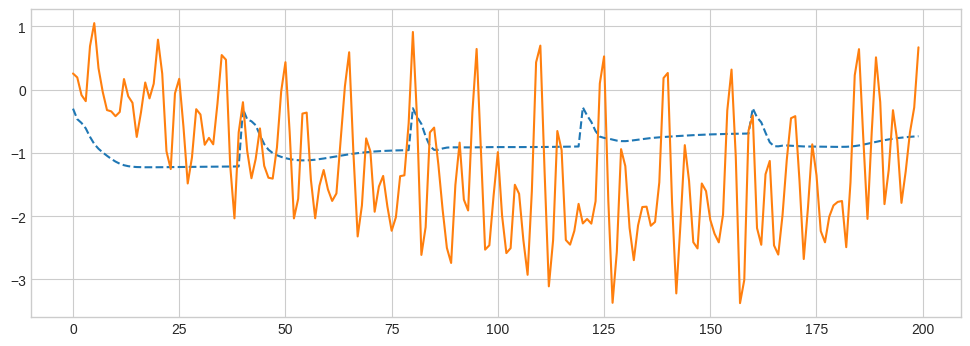

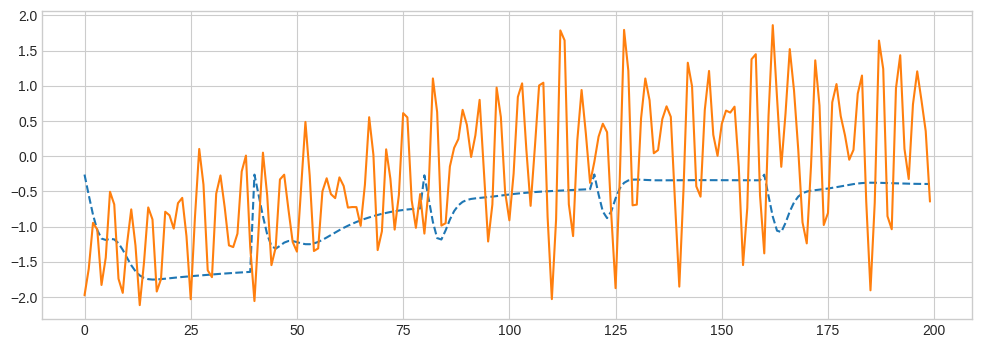

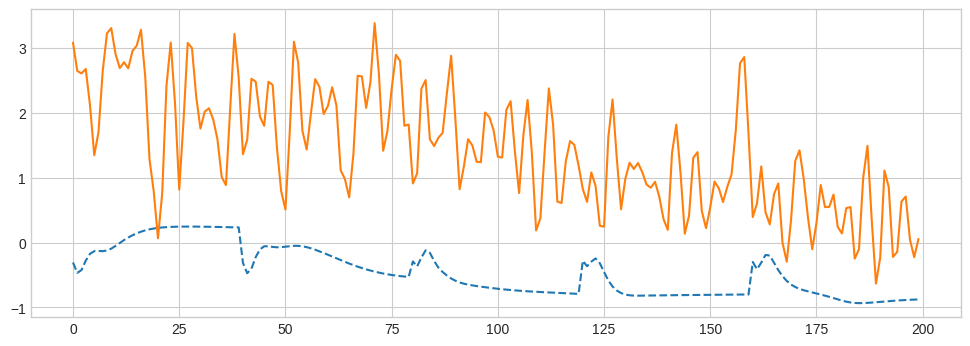

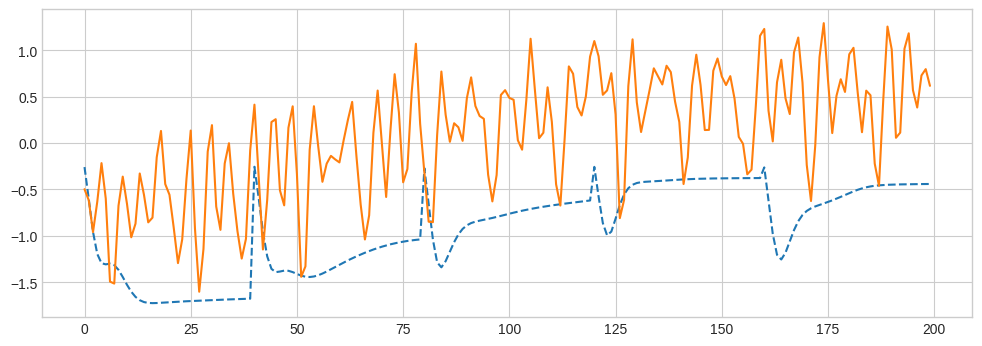

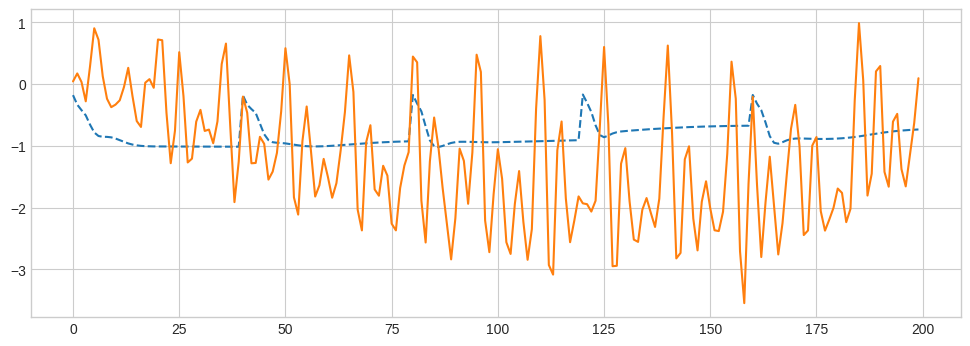

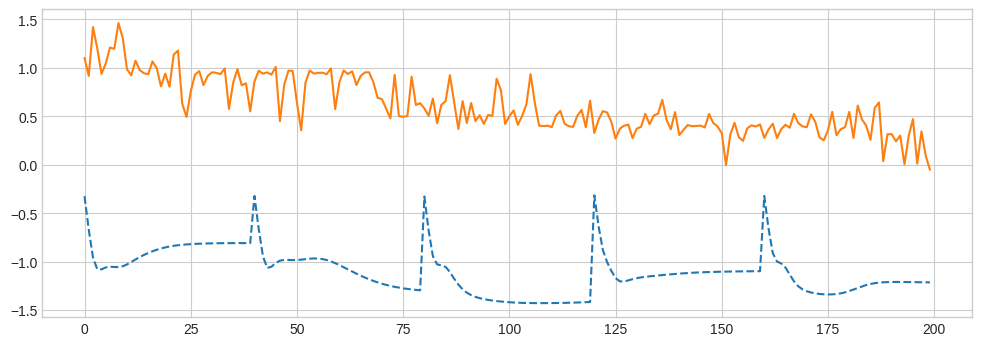

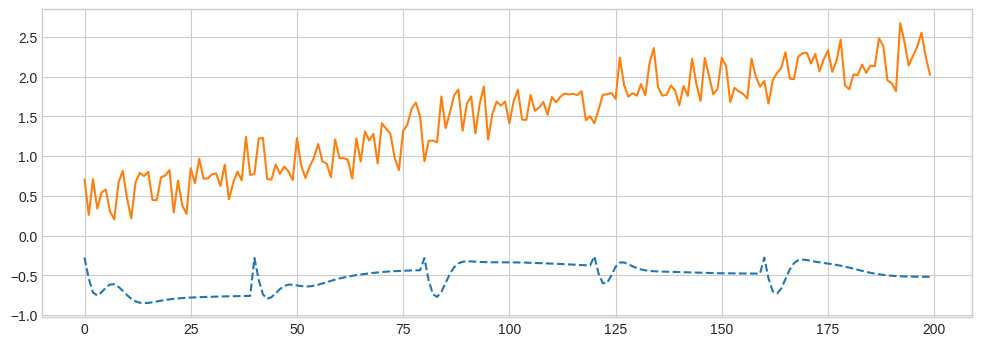

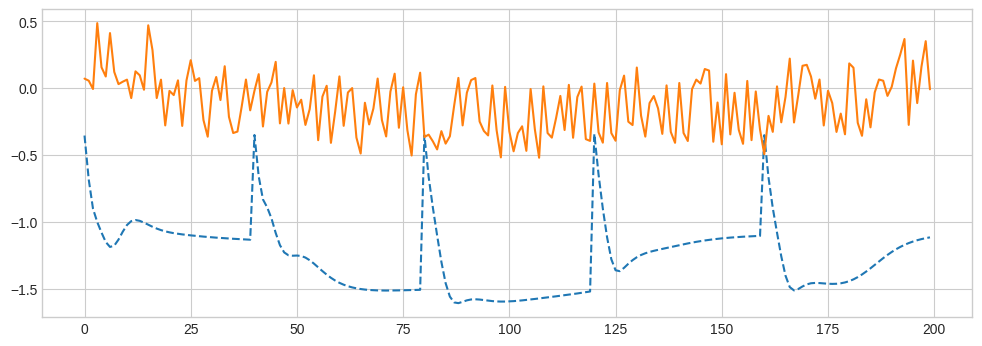

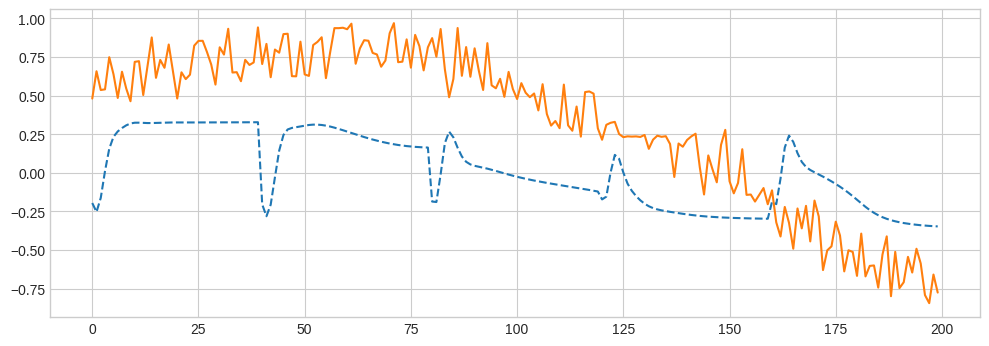

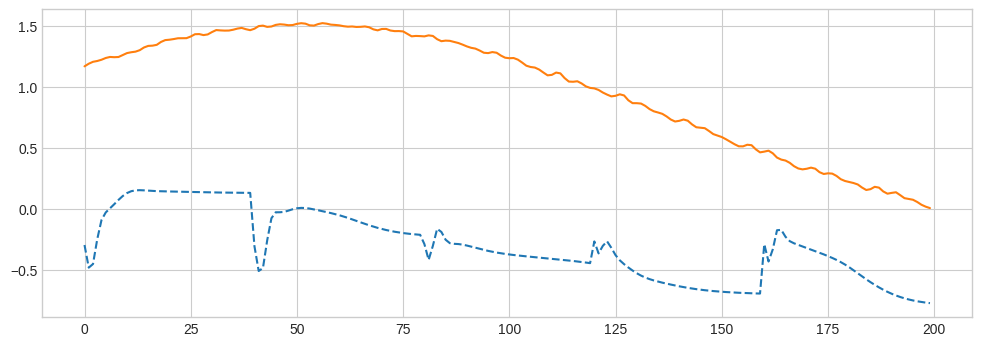

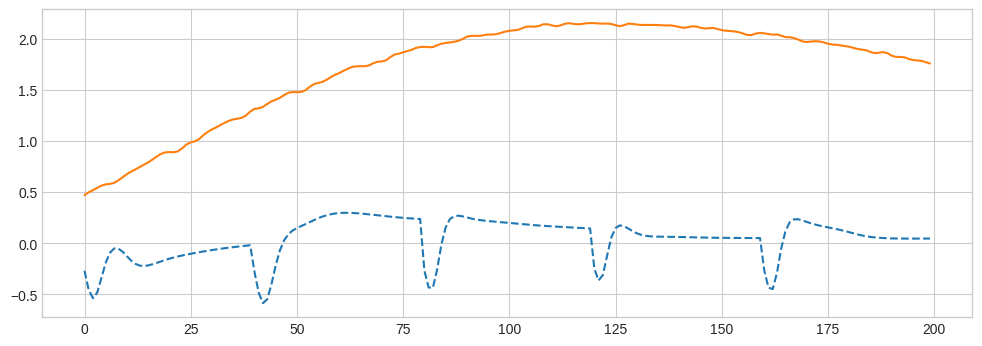

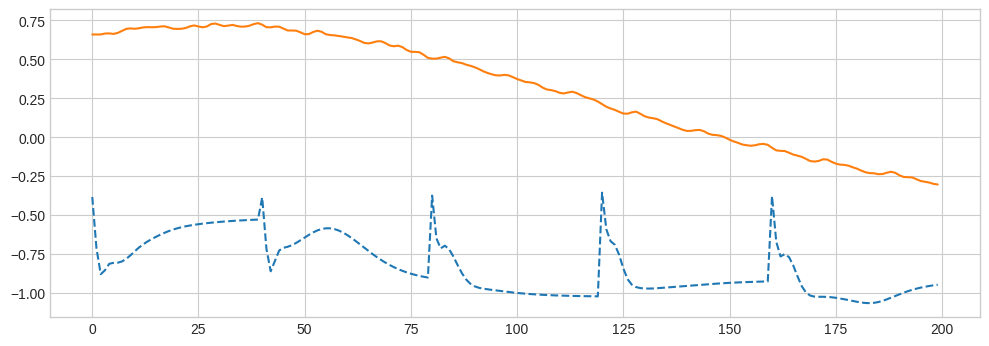

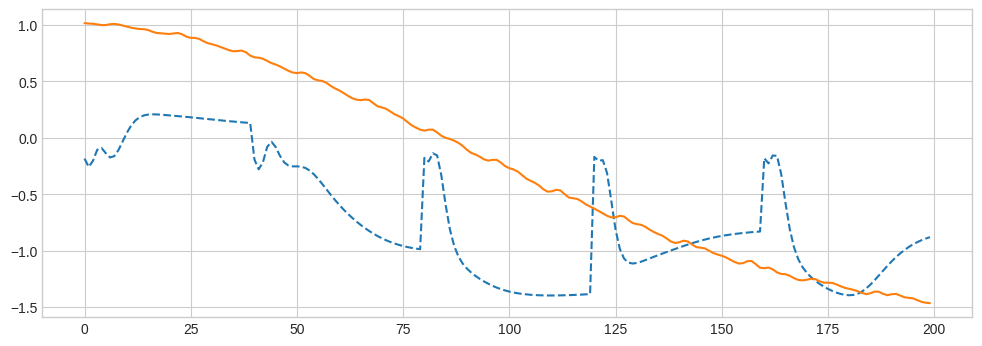

In [19]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

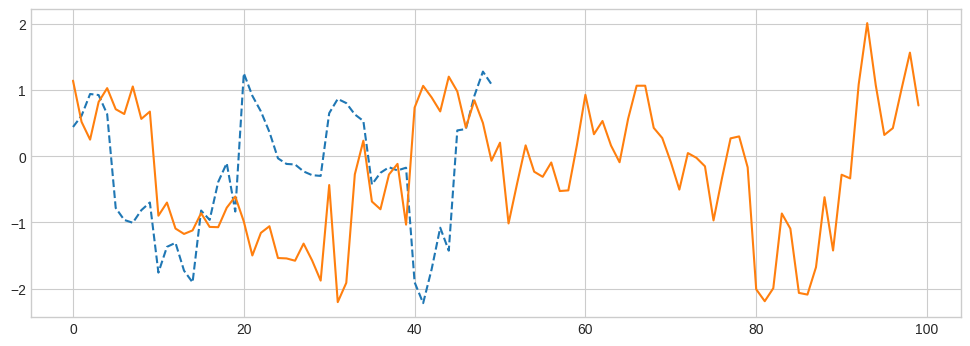

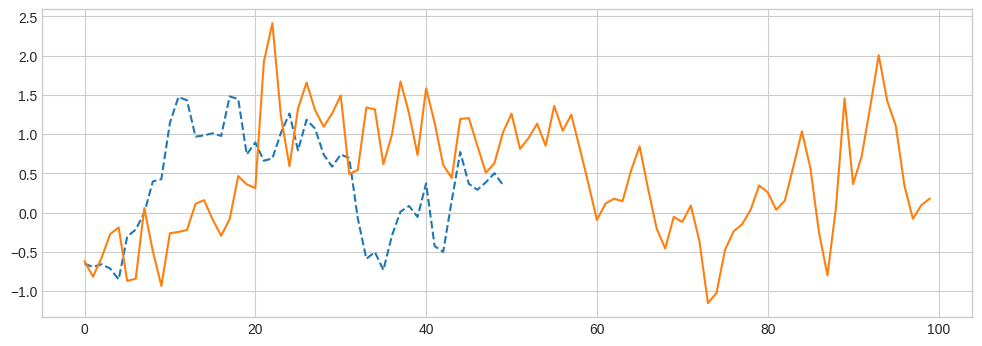

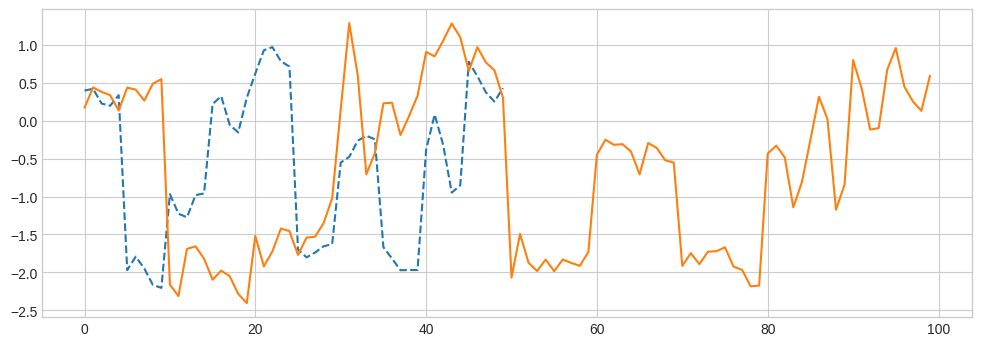

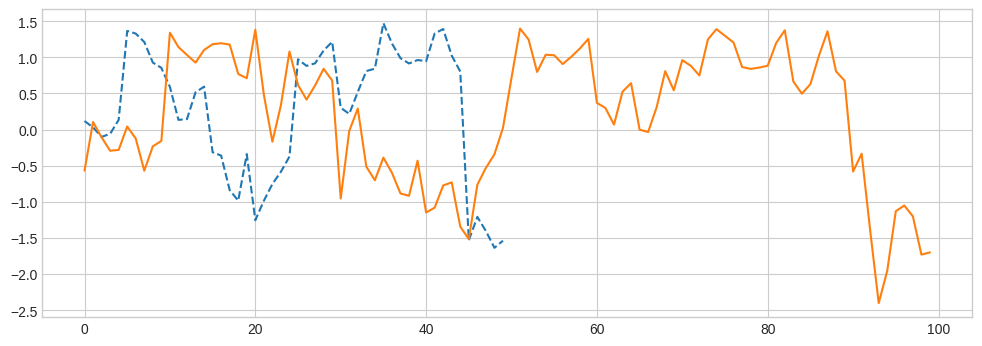

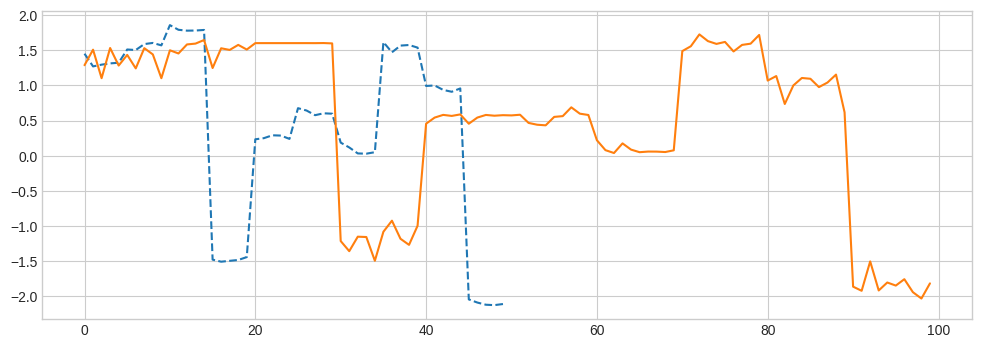

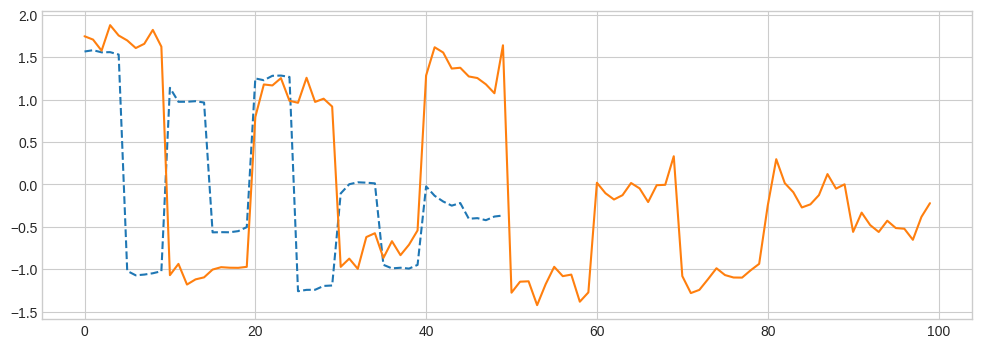

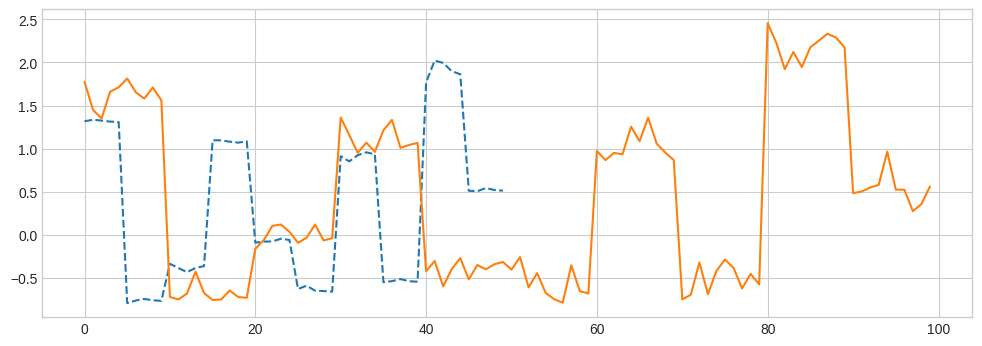

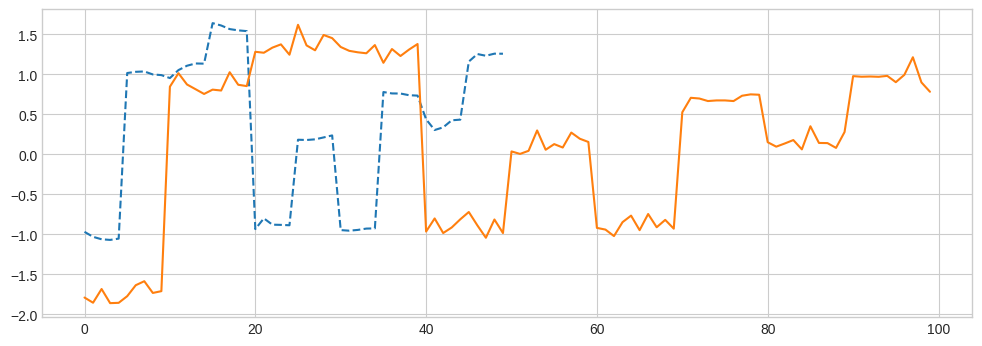

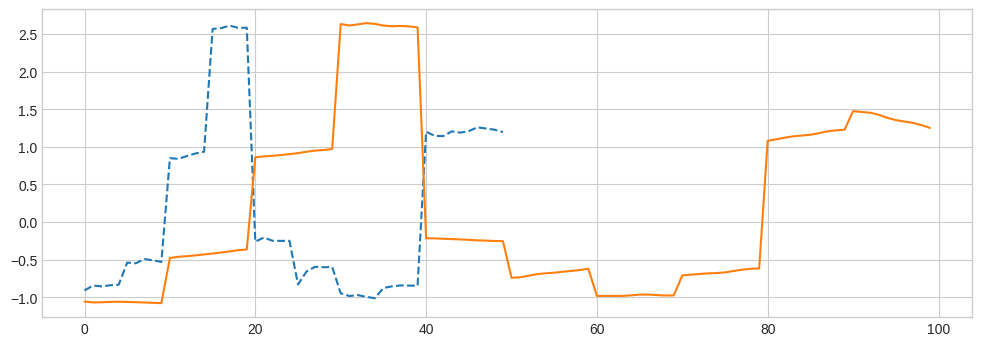

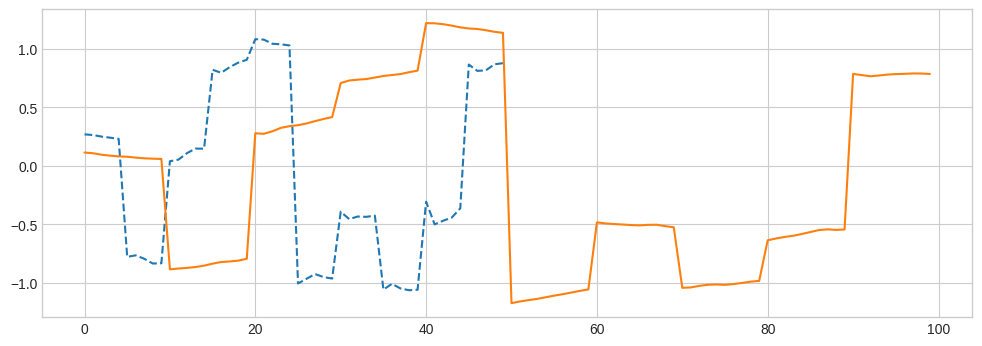

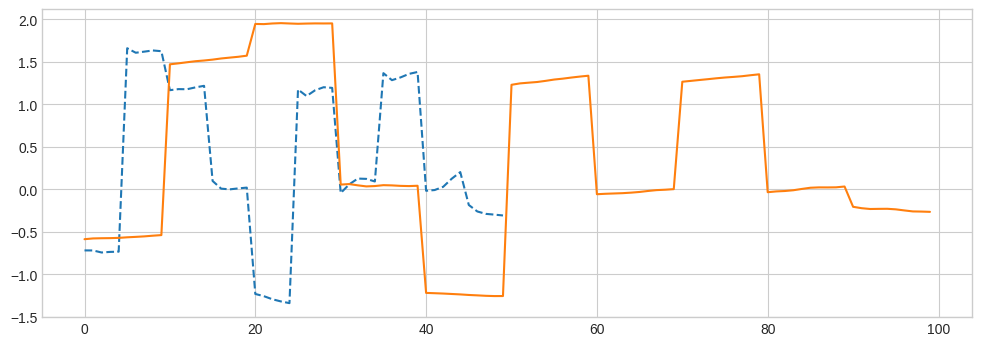

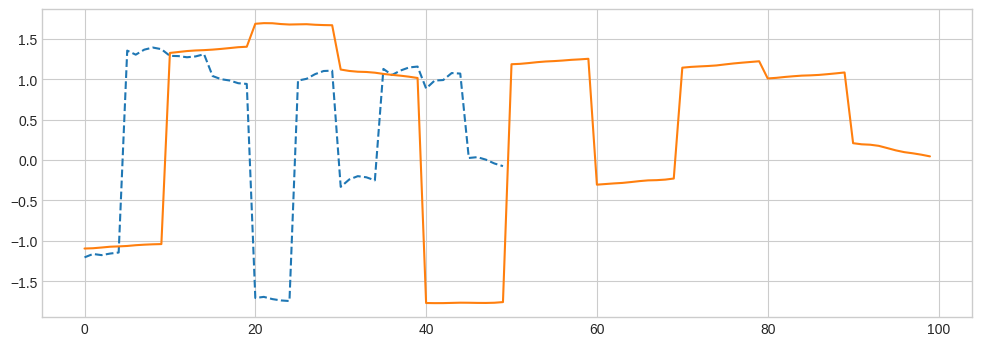

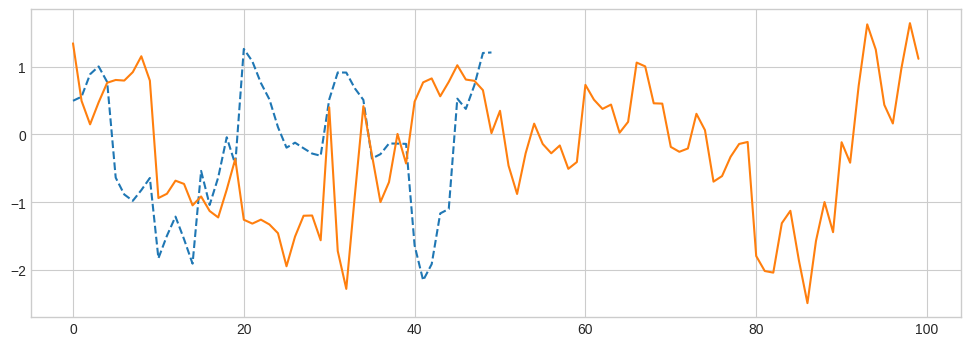

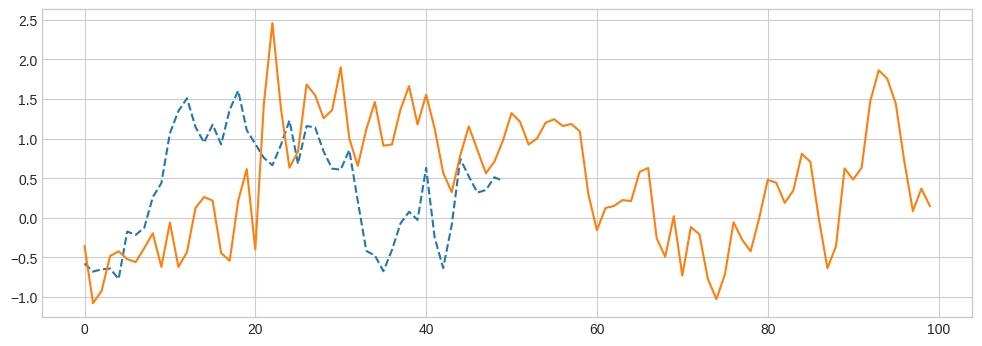

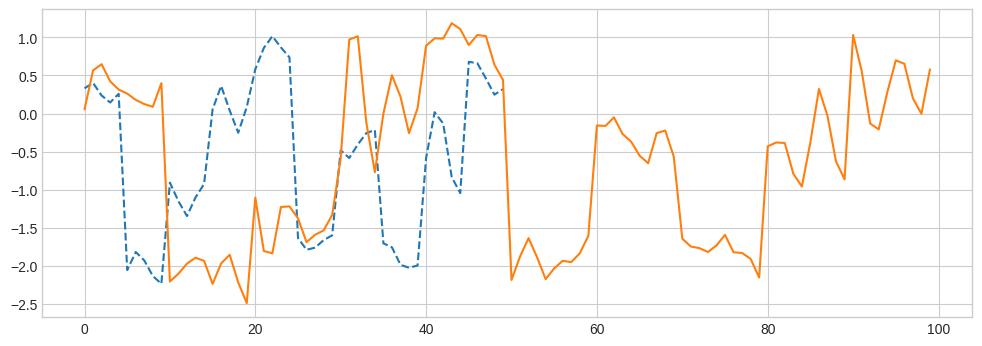

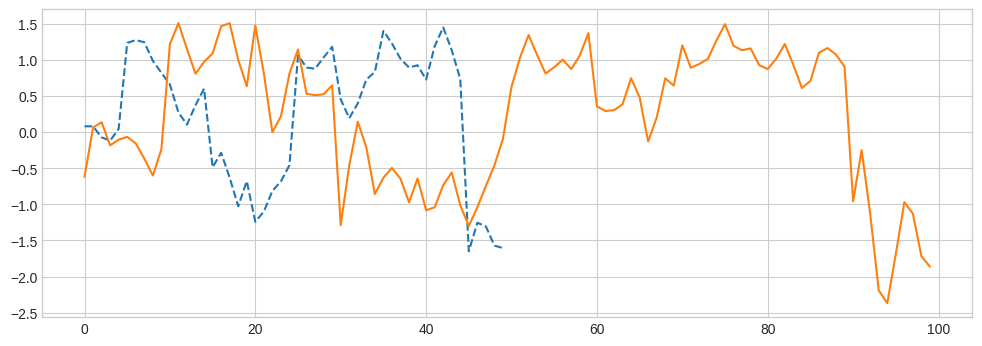

In [15]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:,i].to("cpu").detach().numpy(), linestyle='--')

    plt.plot(x.flatten(0,1)[:,i].to("cpu").detach().numpy())

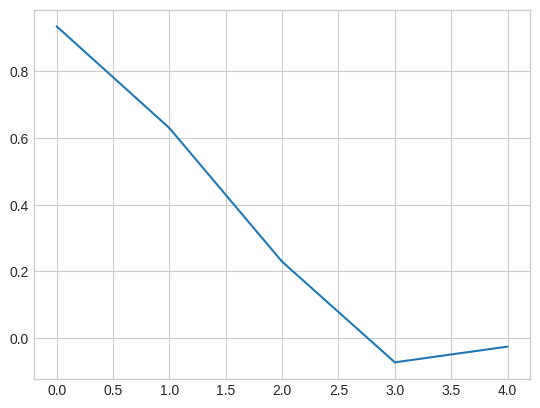

In [18]:
x, y = next(iter(test_iter))
x, enc, yo = model(x.to('cuda'))
feat = 0

if predict:
    plt.plot(y[0,:,feat].to("cpu").detach().numpy())
else:
    plt.plot(x[0,:,feat].to("cpu").detach().numpy())

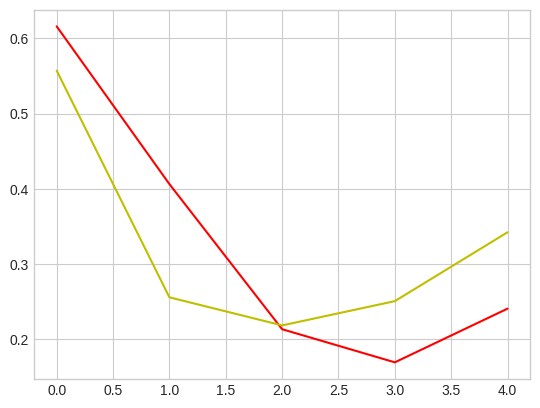

In [19]:
plt.plot(yo[1,:,feat].to("cpu").detach().numpy(), 'r')
plt.plot(y[1,:,feat].to("cpu").detach().numpy(), 'y')

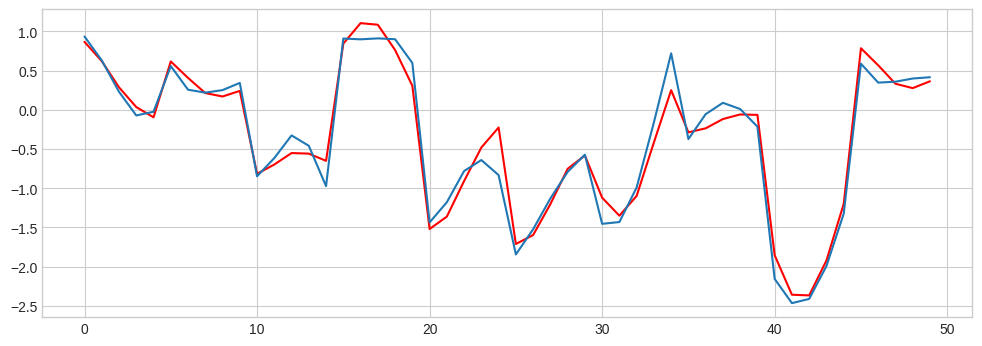

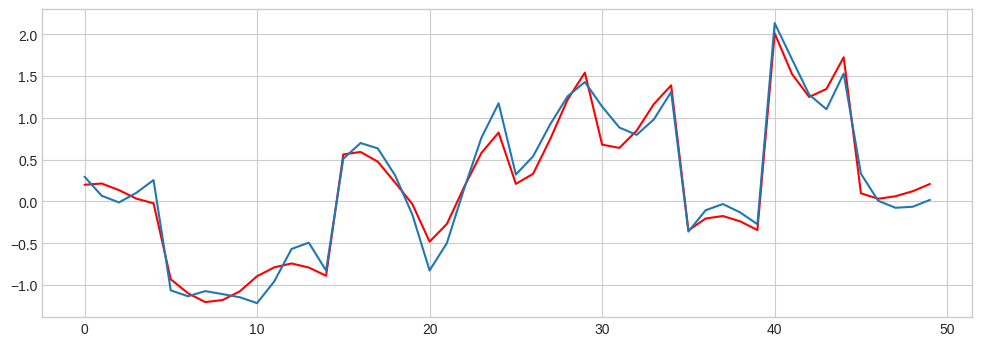

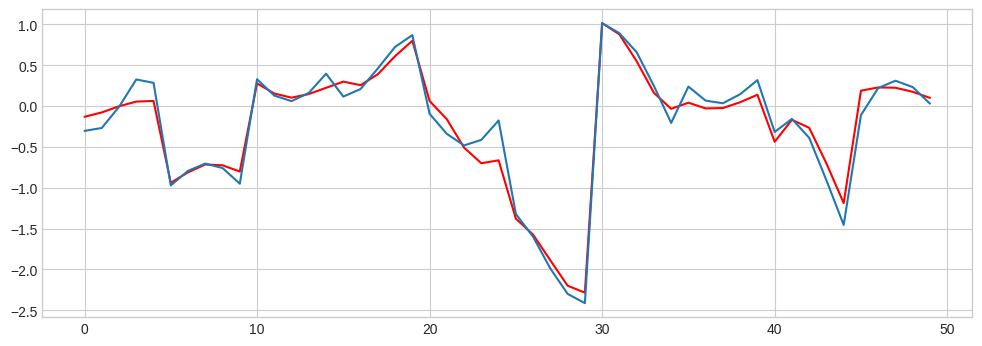

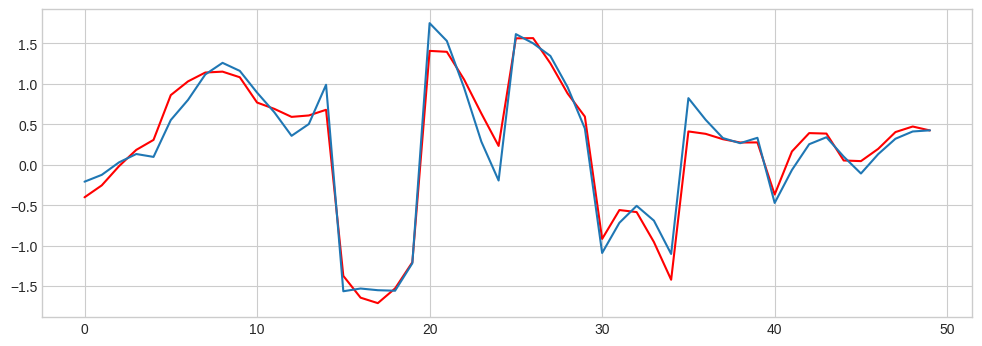

In [20]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(12,4))
    #x = np.linspace(0, sequence_length)
    plt.plot(yo.flatten(0,1)[:100,i].to("cpu").detach().numpy(), 'r')
    plt.plot(x.flatten(0,1)[:100,i].to("cpu").detach().numpy())

#Inject anomaly

In [21]:
x, y = next(iter(test_iter))

In [25]:
n_std = 5

In [26]:
batch = 5
x_a = x.clone()
change_value = [0, 1,2]
injected = []
for i in range(x.shape[2]):
    print(i)
    if i in change_value:
        print('changing')
        inject = list(x_a[batch ,:, i].cpu().numpy())
        inject_anomaly = [t + n_std*np.std(inject)*random.uniform(0.8,1) for t in inject]
        #x_a[batch,:, i] =  torch.Tensor(fake)
        x_a[batch,:, i] = torch.Tensor(inject_anomaly)
        
        injected.append(i)
    
    if all(x_a[batch,:,i]==x[batch,:,i]):
        print('original tensor and anomalous are the same on features',i)

0
changing
1
changing
2
changing
3
original tensor and anomalous are the same on features 3


In [27]:
idx = batch*sequence_length
x_a, enc, yo_a = model(x_a.to('cuda'))
x, enc, yo = model(x.to('cuda'))
len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

40

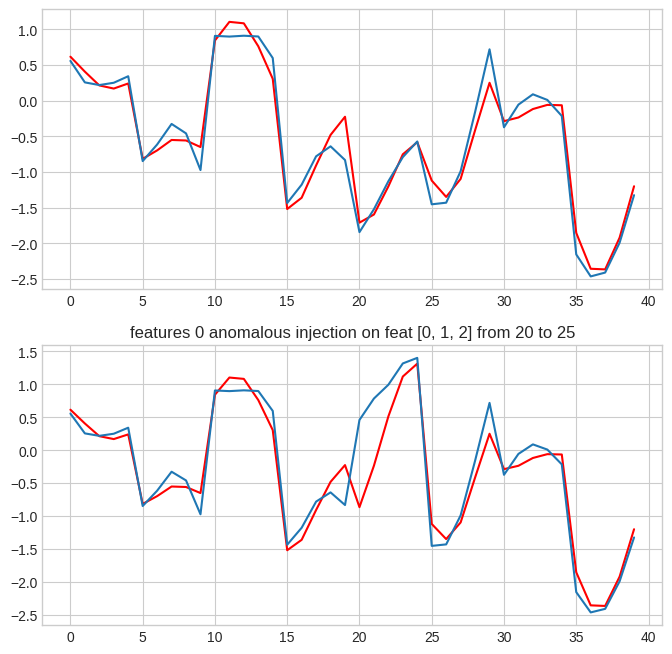

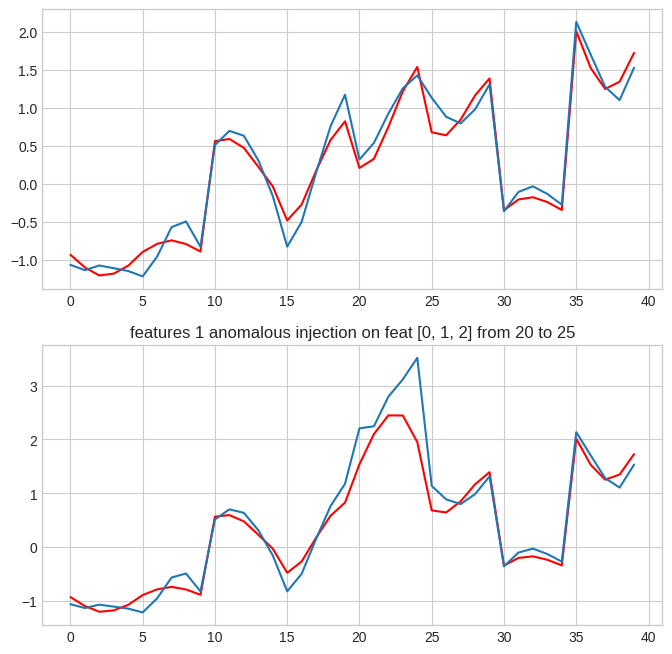

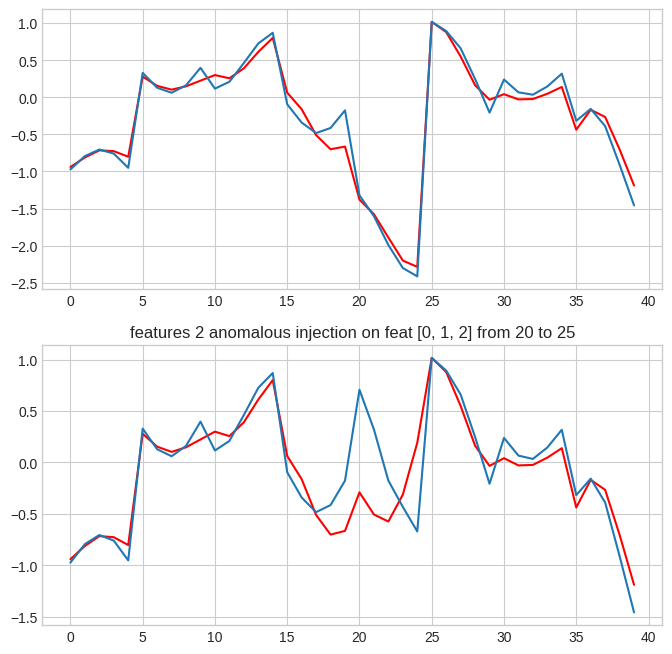

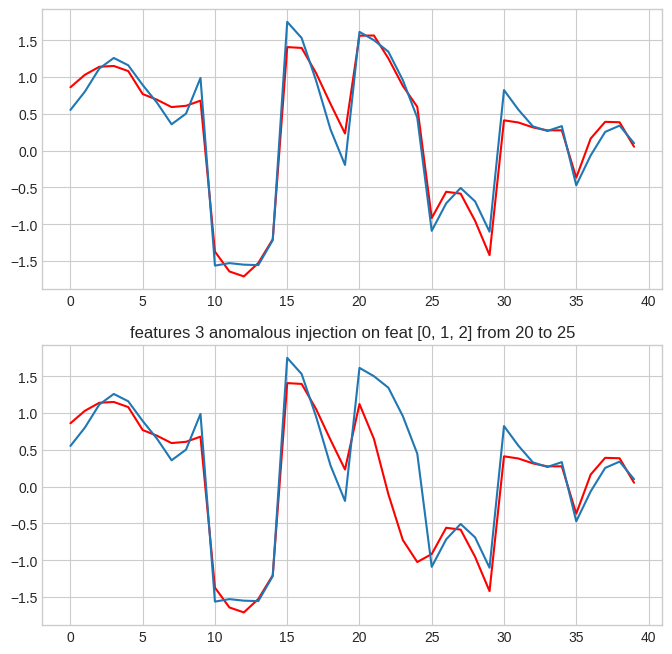

In [28]:
for i in range(x.shape[2]):
    plt.style.use('seaborn-whitegrid')
    fig, axs = plt.subplots(2, figsize=(8,8))
    #x = np.linspace(0, sequence_length)
    axs[0].plot(yo.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[0].plot(x.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())
    plt.title('no anomalies')
    axs[1].plot(yo_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy(), 'r')
    axs[1].plot(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())

    an_idx = len(x_a.flatten(0,1)[idx - 20: idx + 20,i].to("cpu").detach().numpy())//2

    plt.title('features {} anomalous injection on feat {} from {} to {}'\
              .format(i ,injected, int(an_idx), int(an_idx)+ batch))